In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

directory = "C:/Users/rvm/Documents/Ruan/Udacity/Self-Driving Car/AdvancedLaneLineFinding/CarND-Advanced-Lane-Lines/"

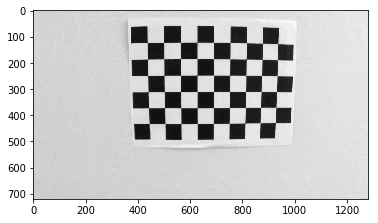

In [2]:
### Importing the camera calibration images

filename = "camera_cal/"
images = []
calImages = [] ### Initialising an array for images

for i in range(1,20):
    image = cv2.imread(directory+filename+'calibration'+ str(i) +'.jpg')
    images.append(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    calImages.append(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)) # Converting the imported images to RGB from BGR due to cv2.imread
index = random.randint(0,len(calImages))
plt.imshow(calImages[index], cmap='gray')
plt.show()

Image:  0  is False
Image:  3  is False


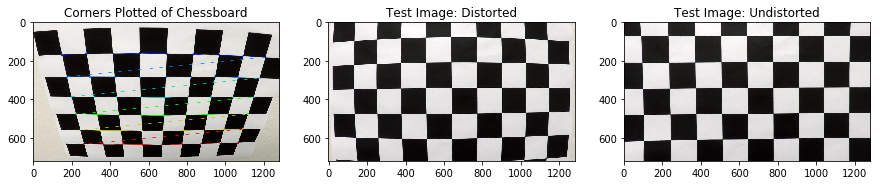

In [3]:
### Calibrating the Camera

corImages = []
objectPoints = []
imagePoints = []
ret = []
objP = np.zeros((9*6,3), np.float32)
objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for j in range(0,len(calImages)):
    retNew, corners = cv2.findChessboardCorners(calImages[j], (9,6), None)
    if retNew == True:
        imagePoints.append(corners) # Appending the corners of each new image into an array
        objectPoints.append(objP)
        ret.append(retNew)
        newImg = cv2.drawChessboardCorners(images[j],(9,6), corners, retNew)
        corImages.append(newImg)
    else:
        print('Image: ',j,' is False') # If corners were not detected in the image.
index = random.randint(0,len(corImages)-1)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('Corners Plotted of Chessboard')
plt.imshow(corImages[0])
plt.subplot(1,3,2)
plt.title('Test Image: Distorted')
plt.imshow(images[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, calImages[1].shape[::-1], None, None)
destinationImage = cv2.undistort(images[0], mtx, dist, None, mtx)
plt.subplot(1,3,3)
plt.title('Test Image: Undistorted')
plt.imshow(destinationImage)
plt.show()

In [4]:
### Previously used functions
import difflib
'''
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def appSobel(img):  ### This function uses sobel in order to calculate the derivative of an image in an axis. The output is a binary image
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abssobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abssobelx/np.max(abssobelx))
    threshmin = 20
    threshmax = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshmin) & (scaled_sobel <= threshmax)] = 1
    return sxbinary
'''            
def makePers(img): ### This function warps the image to a birds eye view

    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[1100, 720],
     [690, 460],
     [590, 460],
     [200, 720]])
    
    dst = np.float32(
    [[1030, 680],
     [980, 0],
     [310, 0],
     [250, 680]])


    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def makeUnPers(img): ### This function takes a warped image and corrects it sgain

    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[1100, 720],
     [690, 460],
     [590, 460],
     [200, 720]])
    
    dst = np.float32(
    [[1030, 680],
     [980, 0],
     [310, 0],
     [250, 680]])


    M = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

def makeSobel(img): ### This function uses sobel in order to calculate the derivative of an image in an axis. The output is a binary image
    threshold = (90, 255)
    
    
    dst = np.zeros_like(img)
    b=cv2.normalize(img,dst,0,255,cv2.NORM_MINMAX)    
    b = cv2.cvtColor(b, cv2.COLOR_RGB2HLS)    
    S = b[:,:,2]
    
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1)
    abssobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abssobelx/np.max(abssobelx))
    threshmin = 10
    threshmax = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshmin) & (scaled_sobel <= threshmax)] = 1
    
    #binary = np.zeros_like(S)
    #binary[(S > threshold[0]) & (S < threshold[1])] = 1  
    
    return sxbinary

leftData = np.zeros([1,720])
def leftLineAvg(leftLine):  ### This function saves each poly line array in order to determine an average (Left Side)
    global leftData

    newLeftLine = np.reshape(leftLine, ((1,720)))
    leftDataShape = np.shape(leftData)    
    
    if (len(leftData)>=2):
        error = (leftData[leftDataShape[0]-1,:]-newLeftLine[0,:])/leftData[leftDataShape[0]-1,:]
        error = np.absolute(np.average(error))
        if (error)>0.18:
            print('left')
            print('Error: ',error)
            leftLine = leftData[leftDataShape[0]-1,:]
        else:
            leftData = np.vstack((leftData, leftLine))
    if len(leftData)==1:
        leftData = np.vstack((leftData, leftLine))
    if len(leftData)<20:
        summ = np.zeros((1,720))
        for i in range(0,len(leftData)):
            summ += leftData[i]
        leftavg = summ/(len(leftData)-1)
    if len(leftData)>=20:
        summ = np.zeros((1,720))
        for j in range(len(leftData)-20,len(leftData)):
            summ += leftData[j]
        leftavg = summ/(20)   
    return (leftavg.reshape((720,)))

rightData = np.zeros([1,720])
def rightLineAvg(rightLine):   ### This function saves each poly line array in order to determine an average (Right Side)
    global rightData    
    newRightLine = np.reshape(rightLine, (1,720))
    rightDataShape = np.shape(rightData)   
    if (len(rightData)>=2):
        error = (rightData[rightDataShape[0]-1,:]-newRightLine[0,:])/rightData[rightDataShape[0]-1,:]
        error = np.absolute(np.average(error))
        if abs(error)>0.045:
            print('right')
            print('Error: ',error)
            rightLine = rightData[rightDataShape[0]-1,:]
        else:
            rightData = np.vstack((rightData, rightLine))
    if len(rightData)==1:
        rightData = np.vstack((rightData, rightLine))
    if len(rightData)<20:
        summ = np.zeros((1,720))
        for i in range(0,len(rightData)):
            summ += rightData[i]
        rightavg = summ/(len(rightData)-1)
    if len(rightData)>=20:
        summ = np.zeros((1,720))
        for j in range(len(rightData)-20,len(rightData)):
            summ += rightData[j]
        rightavg = summ/(20)   
    return (rightavg.reshape((720,)))
    
    
def findHot(img):   ### This function calculates ths polylines that must be fit to an image
    
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    out_img = np.dstack((img, img, img))*255
    #plt.plot(histogram)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 15
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    left_fitx = leftLineAvg(left_fitx)
    right_fitx = rightLineAvg(right_fitx)
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    return left_fitx, right_fitx, ploty, out_img

def imgLayer(img1, img2): ### This function simply masks the line image onto the original image
    α=0.85 
    β=1. 
    λ=0
    
    layers = cv2.addWeighted(img1, α, img2, β, λ)
    
    return layers

def drivingPortion(img, left_fitx, right_fitx): ### This function calculates the drive portion of the lane
    drvPor = np.zeros_like(img)
    α=1.
    β=0.7 
    λ=0
    
    for i in range(0,len(img)):
        drvPor[i, left_fitx[i]:right_fitx[i], 1] = 255
    drvPor = makeUnPers(drvPor)
    drvPortion = cv2.addWeighted(img, α, drvPor, β, λ)
 
    
    return drvPortion

curveData = np.zeros((1,1))
def calcCurve(leftx, rightx, ploty): ### This function calculates the curvature of the lane in world points
    global curveData
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    curveData = np.vstack((curveData, left_curverad)) ### Also calculating an average
    if len(curveData)>10:
        curveAvg = (sum(curveData[len(curveData)-10:len(curveData)]))/10
    else:
        curveAvg = sum(curveData[1:len(curveData)])/(len(curveData)-1)
    
    return curveAvg

def middleCalc(img, leftFit, rightFit): ### Finally this function calculates the offset of the vehicle to the lane center
    imshape = np.shape(img)
    carX = (imshape[1])/2
    laneX = leftFit[len(leftFit)-1]+(rightFit[len(rightFit)-1]-leftFit[len(leftFit)-1])/2
    midVal = (laneX-carX)*(3.7/700)
    return midVal

In [5]:
### Main function

def cam_undist(img, mtx = mtx, dist = dist):
    
    
        
    img = cv2.undistort(img, mtx, dist, None, mtx)   ### Import image
    cleanImg = img
    warped = makePers(img)   ### Warp the image
    sobelLines = makeSobel(warped)   ### Apply Sobel to the warped image
    left_fitx, right_fitx, ploty, outImg = findHot(sobelLines)   ### Find the data points for the polylines
    unwarped = makeUnPers(outImg)   ### Unwarp the image
    layered = imgLayer(cleanImg,unwarped)  ### Mask the lanes onto th original image
    drvPortion = drivingPortion(layered, left_fitx, right_fitx)   ### Calculate the drivable section
    midVal = middleCalc(cleanImg, left_fitx, right_fitx)   ### Calculate the offset of the vehicle to the lane center
    curveVal = calcCurve(left_fitx, right_fitx, ploty)   ### Calculate curvature
    font = cv2.FONT_HERSHEY_DUPLEX   ### The next few lines of code masks the data of curvature and mid points onto the image
    if curveVal < 3000:
        drvPortion = cv2.putText(drvPortion,'Curvature: '+str("%.2f" %curveVal)+'m',(10,100), font, 2,(255,255,255),4)
    else:
        drvPortion = cv2.putText(drvPortion,'Curvature: '+'Straight',(10,100), font, 2,(255,255,255),4)
    if midVal>0:
        drvPortion = cv2.putText(drvPortion,'Car offset from center: '+str("%.2f" %midVal)+'m to Left',(10,200), font, 2,(255,255,255),4)
    else:
        midVal = -midVal
        drvPortion = cv2.putText(drvPortion,'Car offset from center: '+str("%.2f" %midVal)+'m to Right',(10,200), font, 2,(255,255,255),4)
    return (drvPortion)

C:\Users\rvm\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:162: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\rvm\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:254: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


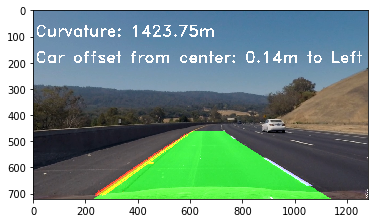

In [6]:
testImage = cv2.imread(directory+'test_images/'+'test3.jpg')

### straight_lines1

plt.imshow(cam_undist(cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB), mtx, dist),cmap='gray')
plt.show()

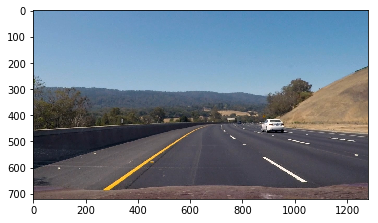

In [7]:
plt.imshow(cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB))

plt.show()

In [8]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'ProjectVideoResult.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(cam_undist) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ProjectVideoResult.mp4
[MoviePy] Writing video ProjectVideoResult.mp4


 48%|█████████████████████████████████████▊                                         | 603/1261 [01:57<02:11,  4.99it/s]

right
Error:  0.0642733429457


 49%|██████████████████████████████████████▎                                        | 612/1261 [01:59<02:05,  5.16it/s]

right
Error:  0.37771107949


 49%|██████████████████████████████████████▍                                        | 613/1261 [01:59<02:11,  4.91it/s]

right
Error:  0.39499213431


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [03:21<00:52,  4.88it/s]

left
Error:  0.181583706667


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [03:28<00:45,  4.87it/s]

right
Error:  0.37503729962


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [03:30<00:43,  4.86it/s]

right
Error:  0.0520529577767


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [03:34<00:39,  4.79it/s]

right
Error:  0.0491016409621


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [03:35<00:41,  4.51it/s]

right
Error:  0.0662451774758


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [03:37<00:39,  4.49it/s]

right
Error:  0.049025312219


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [03:38<00:39,  4.50it/s]

right
Error:  0.103405720352


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [03:40<00:35,  4.64it/s]

right
Error:  0.0457486787357


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [03:40<00:34,  4.72it/s]

right
Error:  0.0494137762776


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [03:40<00:34,  4.80it/s]

right
Error:  0.0581036866199


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [03:40<00:35,  4.59it/s]

right
Error:  0.0522374681395


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [03:41<00:36,  4.49it/s]

right
Error:  0.0553443844042


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [03:41<00:36,  4.42it/s]

right
Error:  0.0559114484059


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [03:59<00:15,  4.97it/s]

right
Error:  0.0598688900265


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [04:06<00:08,  4.79it/s]

right
Error:  0.0652417987584


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [04:07<00:08,  4.83it/s]

right
Error:  0.0718732074305


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [04:07<00:07,  4.94it/s]

right
Error:  0.0666335184138


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [04:07<00:07,  4.89it/s]

right
Error:  0.0703939402066


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [04:07<00:07,  4.69it/s]

right
Error:  0.0665322894224


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [04:08<00:07,  4.60it/s]

right
Error:  0.063575840852


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [04:08<00:07,  4.48it/s]

right
Error:  0.0628684848651


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [04:08<00:07,  4.33it/s]

right
Error:  0.0595145853942


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [04:08<00:07,  4.33it/s]

right
Error:  0.0525931643233


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [04:09<00:06,  4.41it/s]

right
Error:  0.0592744116819


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [04:09<00:06,  4.31it/s]

right
Error:  0.0622195153299


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [04:09<00:06,  4.44it/s]

right
Error:  0.0579287176829


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [04:10<00:05,  4.64it/s]

right
Error:  0.0562480892062


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [04:10<00:05,  4.76it/s]

right
Error:  0.0526482391747


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [04:10<00:04,  4.85it/s]

right
Error:  0.0531325844859


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [04:10<00:04,  4.62it/s]

right
Error:  0.0585478520378


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [04:10<00:04,  4.62it/s]

right
Error:  0.0572990238015


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [04:11<00:04,  4.42it/s]

right
Error:  0.0625478888286


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [04:11<00:04,  4.46it/s]

right
Error:  0.0572288686332


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [04:11<00:04,  4.31it/s]

right
Error:  0.0559209706873


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [04:11<00:04,  4.41it/s]

right
Error:  0.0625311964039


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [04:12<00:03,  4.66it/s]

right
Error:  0.0617526739303


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [04:12<00:03,  4.76it/s]

right
Error:  0.0614740288793


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [04:12<00:03,  4.85it/s]

right
Error:  0.0705461691482


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [04:12<00:03,  4.66it/s]

right
Error:  0.069065933659


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [04:12<00:02,  4.53it/s]

right
Error:  0.072199708951


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [04:13<00:02,  4.53it/s]

right
Error:  0.0764661677531


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [04:13<00:02,  4.45it/s]

right
Error:  0.0745976074313


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [04:13<00:02,  4.41it/s]

right
Error:  0.0752633362155


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [04:13<00:02,  4.39it/s]

right
Error:  0.0719649976056


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [04:14<00:01,  4.73it/s]

right
Error:  0.0722743424646


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [04:14<00:01,  4.76it/s]

right
Error:  0.0790394849312


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [04:14<00:01,  4.88it/s]

right
Error:  0.0834752714862


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [04:14<00:01,  4.74it/s]

right
Error:  0.0857703303426


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [04:14<00:00,  4.62it/s]

right
Error:  0.0920389276908


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [04:15<00:00,  4.63it/s]

right
Error:  0.0919798400329


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [04:15<00:00,  4.53it/s]

right
Error:  0.0952341407064


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:15<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ProjectVideoResult.mp4 

Wall time: 4min 17s
